In [285]:
import matplotlib.pyplot as plt
import pandas as pd
import scikit_posthocs as sp
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import f_oneway, kruskal, levene, shapiro, ttest_ind, wilcoxon
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.proportion import proportion_confint, proportions_ztest

import numpy as np


In [213]:
df_ab = pd.read_csv("ab_test_data.csv")
df_ab.head()

,user_id,variant,converted,purchase_amount
0,0,A,0,0.000000
1,1,A,1,50.433272
2,2,A,0,0.000000
3,3,A,0,0.000000
4,4,A,0,0.000000


### Questions - Partie 1

**Q1.1** : Calculez le taux de conversion pour chaque variante. Quelle est la différence absolue et relative ?

In [214]:
conversion_rates = (
    df_ab.groupby("variant").agg(conversion_rate=("converted", "mean")).sort_index()
)

conversion_rate_A = conversion_rates.loc["A", "conversion_rate"]
conversion_rate_B = conversion_rates.loc["B", "conversion_rate"]
print("Taux de conversion A (en %) : ", conversion_rate_A * 100)
print("Taux de conversion B (en %) : ", conversion_rate_B * 100)
print("Différence absolue (en %) : ", abs(conversion_rate_B - conversion_rate_A) * 100)
print(
    "Différence relative (en %) : ",
    (conversion_rate_B - conversion_rate_A) / conversion_rate_A * 100,
)

Taux de conversion A (en %) :  11.76
Taux de conversion B (en %) :  13.48
Différence absolue (en %) :  1.7200000000000006
Différence relative (en %) :  14.62585034013606


**Q1.2** : Visualisez les taux de conversion avec un graphique en barres avec intervalles de confiance.

Intervalle de confiance A :  [0.10555533 0.1219719 ]
Intervalle de confiance A :  [0.13081805 0.14874869]


Text(0.5, 1.0, 'Taux de conversion avec IC 95%')

<Figure size 700x500 with 0 Axes>

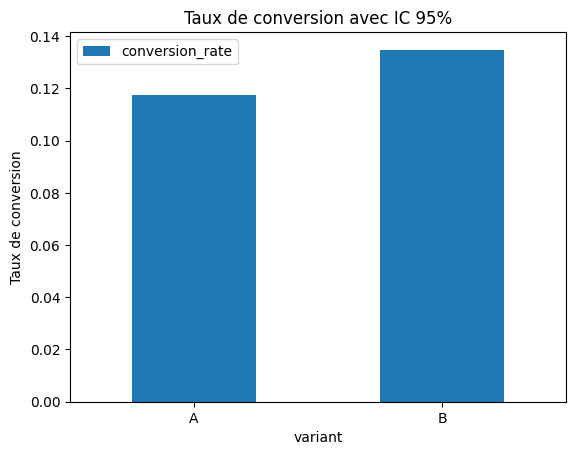

In [215]:
# Calcul des intervalles de confiances
conversion_sum = (
    df_ab.groupby("variant").agg(conversion_sum=("converted", "sum")).sort_index()
)
conversion_size = (
    df_ab.groupby("variant").agg(conversion_size=("converted", "size")).sort_index()
)
ci = proportion_confint(
    count=conversion_sum.values,
    nobs=conversion_size.values,
    alpha=0.05,
    method="wilson",
)
print("Intervalle de confiance A : ", ci[0].flatten())
print("Intervalle de confiance A : ", ci[1].flatten())

# Graphique
plt.figure(figsize=(7, 5))
conversion_rates.plot.bar(rot=0)

plt.ylabel("Taux de conversion")
plt.title("Taux de conversion avec IC 95%")

**Q1.3** : Avant de réaliser le test statistique, vérifiez les conditions d'application :
- Les observations sont-elles indépendantes ?
- L'échantillon est-il suffisamment grand ?

- Les observations sont suposées indépedantes.
- Il nous faut n * p > 5 et n * (1 - p) > 5 pour les deux variants
  - variant A : 2500 * 0.11 = 275 > 5 et 2500 * 0.89 = 2225 > 5
  - variant B : 2500 * 0.13 = 325 > 5 et 2500 * 0.87 = 2175 > 5

**Q1.4** : Réalisez un test de proportion (test z) pour comparer les taux de conversion. Formulez les hypothèses H0 et H1.

H0 : Les proportions sont égales

H1 : Les proportions sont différentes

In [216]:
conversion_count = df_ab.groupby("variant")["converted"].sum()
n = df_ab.groupby("variant")["converted"].count()

z_stat, p_value = proportions_ztest(conversion_count.values, n.values)
print(f"z-stat: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

z-stat: -1.8313
p-value: 0.0671


**Q1.5** : Interprétez la p-value obtenue. La différence est-elle statistiquement significative au seuil α = 0.05 ?

- p-value = 0.0671 > 0.05 donc on ne rejette pas l'hypothèse H0, les proportions sont égales.

**Q1.6** : Calculez la **lift** (amélioration relative) et l'**intervalle de confiance à 95%** de la différence.

In [217]:
print(
    "Lift (en %) : ",
    (conversion_rate_B - conversion_rate_A) / conversion_rate_A * 100,
)

Lift (en %) :  14.62585034013606


**Q1.7** : **Analyse du montant moyen des achats** : Comparez le montant moyen dépensé par les utilisateurs qui ont converti entre les deux variantes. Utilisez un test t de Student.

In [218]:
df_converted = df_ab[df_ab["converted"] == 1].copy()

purchase_amount_means = df_converted.groupby("variant").agg(
    purchase_amount_mean=("purchase_amount", "mean")
)

purchase_amount_mean_A = purchase_amount_means.loc["A", "purchase_amount_mean"]
purchase_amount_mean_B = purchase_amount_means.loc["B", "purchase_amount_mean"]
print("Moyenne de purchase_amount A : ", purchase_amount_mean_A)
print("Moyenne de purchase_amount B : ", purchase_amount_mean_B)
print(
    "Différence absolue des moyennes : ",
    abs(purchase_amount_mean_B - purchase_amount_mean_A),
)
print(
    "Différence relative des moyennes : ",
    (purchase_amount_mean_B - purchase_amount_mean_A) / purchase_amount_mean_A,
)

Moyenne de purchase_amount A :  99.59507292904826
Moyenne de purchase_amount B :  103.14468045914587
Différence absolue des moyennes :  3.5496075300976173
Différence relative des moyennes :  0.035640392900021925


Test de Shapiro-Wilk

In [219]:
df_A = df_converted[df_converted["variant"] == "A"]["purchase_amount"]
stat_shapiro_A, p_shapiro_A = shapiro(df_A)
print("p_value A : ", p_shapiro_A)

df_B = df_converted[df_converted["variant"] == "B"]["purchase_amount"]
stat_shapiro_B, p_shapiro_B = shapiro(df_B)
print("p_value B : ", p_shapiro_B)

p_value A :  2.9276694499236653e-08
p_value B :  3.9913306531089e-16


- On rejette l'hypothèse H0 pour les deux écahntillons, on accepte la normalité des échantillons.

Test de Levene

In [220]:
stat_levene, p_levene = levene(df_A, df_B)
print("p_value : ", p_levene)

p_value :  0.6908383944109123


- p_value = 0.69 >> 0.05, donc on ne rejette pas l'hypothèse H0, les variances sont homogènes.

H0 : Les moyennes sont égales

H1 : Les moyennes sont différentes

In [221]:
t_stat, p_value_t = ttest_ind(df_A, df_B, equal_var=True)
print("p_value : ", p_value_t)

p_value :  0.5244485686646174


- p_value = 0.52 >> 0.05, on ne rejette pas H0, les moyennes ne sont pas significativement différentes.

**Q1.8** : **Calcul de la puissance** : Avec la taille d'échantillon actuelle, quelle est la puissance statistique de votre test ?

In [222]:
def cohens_d(group1, group2):
    # Calculating means of the two groups
    mean1, mean2 = np.mean(group1), np.mean(group2)

    # Calculating pooled standard deviation
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    n1, n2 = len(group1), len(group2)
    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))

    # Calculating Cohen's d
    return abs(mean1 - mean2) / pooled_std


# Calculating Cohen's d
effect_size = cohens_d(df_A, df_B)
print("Cohen's d:", effect_size)

Cohen's d: 0.05082403882511149


- La taille d'effet est de 0.05, donc l'effet est négligeable.
- Le calcul de la puissance du test n'a de sens que si l'effet n'est pas négligeable.

**Q1.9** : **Recommandation Business** : Que recommandez-vous à l'équipe produit ? Considérez à la fois la significativité statistique et la significativité pratique.

- L'analyse statistique ne montre pas d'effet significatif.
- Nous recommandons de prolonger le test pour récupérer plus de données et d'attendre avant le déployement.

### Questions - Partie 2

**Q2.1** : Calculez les statistiques descriptives pour chaque groupe (moyenne, médiane, écart-type, quartiles).

In [223]:
df_promo = pd.read_csv("promotion_test_data.csv")
df_promo.head()

,user_id,promotion_type,basket_amount
0,0,Control,57.859235
1,1,Control,109.933636
2,2,Control,92.074462
3,3,Control,47.342632
4,4,Control,70.534994


In [224]:
stats_promo = df_promo.groupby("promotion_type").agg(
    mean_=("basket_amount", "mean"),
    std_=("basket_amount", "std"),
    min_=("basket_amount", "min"),
    max_=("basket_amount", "max"),
    q1_=("basket_amount", lambda x: np.percentile(x, 0.25)),
    q2_=("basket_amount", lambda x: np.percentile(x, 0.5)),
    q3_=("basket_amount", lambda x: np.percentile(x, 0.75)),
)
stats_promo.head()

,mean_,std_,min_,max_,q1_,q2_,q3_
promotion_type,,,,,,,
Combo,103.644339,29.104643,9.988340,181.676834,18.649280,27.781783,34.704164
Control,84.270352,25.706516,4.223625,158.965636,12.305331,18.024262,21.864036
Discount_10,92.023002,26.437093,16.720952,161.115956,19.883042,23.468634,26.067172
Free_Shipping,96.738405,26.347421,25.343720,190.861060,32.527595,37.379208,40.164183


**Q2.2** : Créez une visualisation comparative (boxplot ou violin plot) des montants par groupe de promotion.

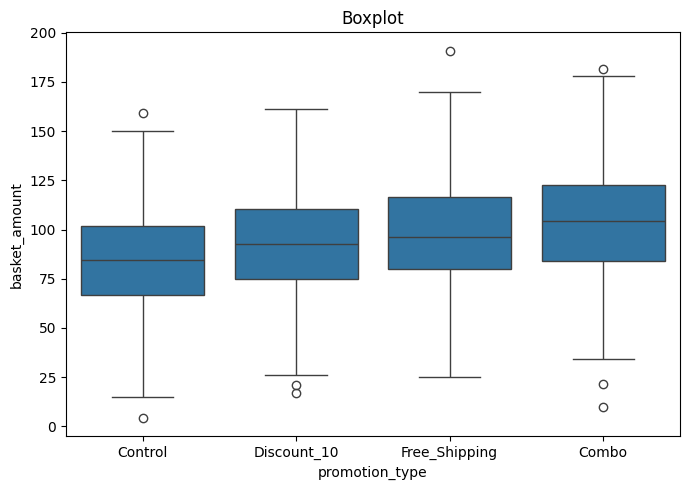

In [225]:
plt.figure(figsize=(7, 5))
plt.title("Boxplot")
sns.boxplot(df_promo, x="promotion_type", y="basket_amount")
plt.tight_layout()

**Q2.3** : **Vérification des conditions de l'ANOVA** :
- Testez la normalité des résidus (Shapiro-Wilk ou Q-Q plot)
- Testez l'homogénéité des variances (test de Levene)
- Les conditions sont-elles respectées ?

In [226]:
df_control = df_promo[df_promo["promotion_type"] == "Control"]
df_discount_10 = df_promo[df_promo["promotion_type"] == "Discount_10"]
df_free_shipping = df_promo[df_promo["promotion_type"] == "Free_Shipping"]
df_combo = df_promo[df_promo["promotion_type"] == "Combo"]

for name, df in zip(
    ["Control", "Discount_10", "Free_Shipping", "Combo"],
    [df_control, df_discount_10, df_free_shipping, df_combo],
):
    stat, p_value = shapiro(df["basket_amount"])
    print(f"p-value {name} : ", p_value)

p-value Control :  0.998900153269173
p-value Discount_10 :  0.7452944835364376
p-value Free_Shipping :  0.545475484164444
p-value Combo :  0.45092353133729857


On ne rejette la normalité d'aucun échantillon.

In [227]:
stat_levene, p_value_levene = levene(
    df_control["basket_amount"],
    df_discount_10["basket_amount"],
    df_free_shipping["basket_amount"],
    df_combo["basket_amount"],
)
print("p-value : ", p_value_levene)

p-value :  0.2005347794175113


On ne rejette pas l'homogénéité des échantillons.

**Q2.4** : Réalisez une **ANOVA à un facteur** pour tester s'il existe une différence significative entre les groupes.

In [228]:
model = ols(
    "basket_amount ~ C(promotion_type)",
    data=df_promo[["promotion_type", "basket_amount"]],
).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("Table ANOVA :")
print(anova_table)

Table ANOVA :
                          sum_sq      df          F        PR(>F)
C(promotion_type)   59691.730082     3.0  27.434902  3.685783e-17
Residual           867402.511971  1196.0        NaN           NaN


H0 : Les moyennes sont égales

H1 : Au moins une des moyennes est différente des autres

- p-value << 0.05 donc on rejette H0, au moins l'une des moyenne est significativement différente des autres.

**Q2.5** : Si l'ANOVA est significative, réalisez des **tests post-hoc de Tukey** pour identifier quels groupes diffèrent significativement.

In [229]:
tukey = pairwise_tukeyhsd(
    df_promo["basket_amount"], df_promo["promotion_type"], alpha=0.05
)
print(tukey)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
   group1       group2    meandiff p-adj   lower    upper   reject
------------------------------------------------------------------
      Combo       Control  -19.374    0.0 -25.0309 -13.7171   True
      Combo   Discount_10 -11.6213    0.0 -17.2782  -5.9644   True
      Combo Free_Shipping  -6.9059 0.0093 -12.5628   -1.249   True
    Control   Discount_10   7.7527 0.0025   2.0957  13.4096   True
    Control Free_Shipping  12.4681    0.0   6.8111   18.125   True
Discount_10 Free_Shipping   4.7154 0.1398  -0.9415  10.3723  False
------------------------------------------------------------------


**Q2.6** : Calculez l'**eta-squared (η²)** pour mesurer la taille d'effet. Comment interprétez-vous cette valeur ?

In [230]:
def compute_eta_squared(anova_table):
    anova_table["eta_sq"] = anova_table[:-1]["sum_sq"] / sum(anova_table["sum_sq"])
    return anova_table


anova_table_with_eta2 = compute_eta_squared(anova_table)

print("Table ANOVA avec eta squared:")
print(anova_table_with_eta2)

Table ANOVA avec eta squared:
                          sum_sq      df          F        PR(>F)    eta_sq
C(promotion_type)   59691.730082     3.0  27.434902  3.685783e-17  0.064386
Residual           867402.511971  1196.0        NaN           NaN       NaN


- eta_suared = 0.06 donc l'effet est négligeable.

**Q2.7** : **Scénario alternatif** : Si les conditions de l'ANOVA n'étaient pas respectées, quel test auriez-vous utilisé ? Réalisez ce test pour comparer.

In [251]:
stat_kruscal, p_value_kruskal = kruskal(
    df_control["promotion_type"],
    df_discount_10["promotion_type"],
    df_free_shipping["promotion_type"],
    df_combo["promotion_type"],
)
print("p-value", p_value_kruskal)

p-value 1.2082853612107343e-259


- On rejette encore H0, au moins une moyenne est significativement différente des autres.

**Q2.8** : **Recommandation Business** :
- Quelle stratégie de promotion recommandez-vous ?
- Analysez le ROI potentiel de chaque promotion
- Y a-t-il des promotions à éviter ?

### Questions - Partie 3

**Q3.1** : Visualisez la distribution des temps de chargement pour chaque algorithme (histogrammes + boxplots).

In [232]:
df_algo = pd.read_csv("algorithm_performance_data.csv")
df_algo.head()

,request_id,algorithm,loading_time_ms
0,0,Collaborative,94.435863
1,1,Collaborative,110.267081
2,2,Collaborative,408.879060
3,3,Collaborative,477.979240
4,4,Collaborative,125.890182


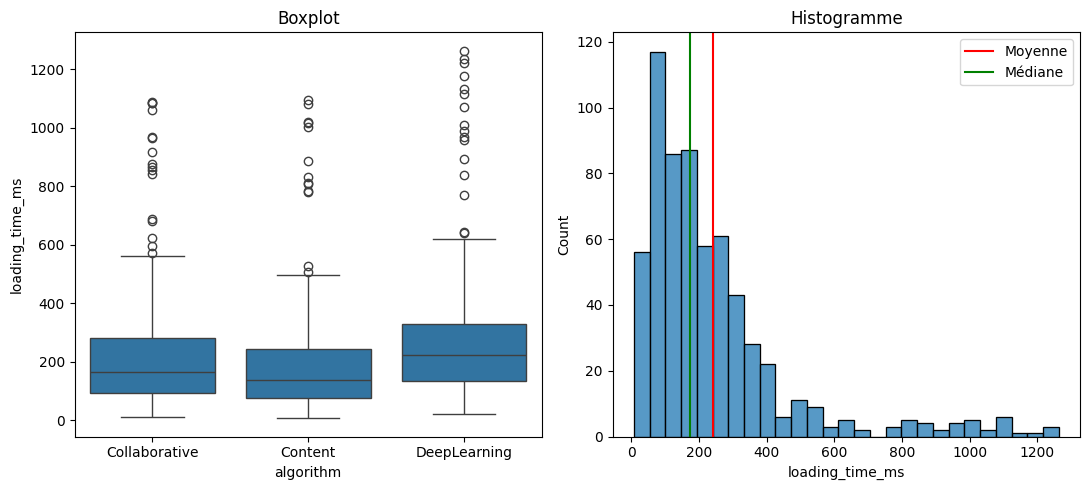

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))

ax1 = axes[0]
sns.boxplot(df_algo, x="algorithm", y="loading_time_ms", ax=ax1)
ax1.set_title("Boxplot")

ax2 = axes[1]
sns.histplot(df_algo, x="loading_time_ms", ax=ax2)
ax2.axvline(x=df_algo["loading_time_ms"].mean(), color="red", label="Moyenne")
ax2.axvline(x=df_algo["loading_time_ms"].median(), color="green", label="Médiane")
ax2.set_title("Histogramme")

plt.legend()
plt.tight_layout()

**Q3.2** : Testez la normalité des données pour chaque groupe. Sont-elles normalement distribuées ?

In [250]:
df_collaborative = df_algo[df_algo["algorithm"] == "Collaborative"]
df_content = df_algo[df_algo["algorithm"] == "Content"]
df_deeplearning = df_algo[df_algo["algorithm"] == "DeepLearning"]

for name, df in zip(
    ["Collaborative", "Content", "DeepLearning"],
    [df_collaborative, df_content, df_deeplearning],
):
    stat, p_value = shapiro(df["loading_time_ms"])
    print(f"p-value {name} : ", p_value)

p-value Collaborative :  3.3692967545735894e-17
p-value Content :  1.321102855756407e-18
p-value DeepLearning :  2.2733304476912288e-17


- On rejette la normalité pour tous les échantillons.

**Q3.3** : Compte tenu de la distribution des données, justifiez le choix entre ANOVA et Kruskal-Wallis.

- Les distributions n'étant pas normale, on ne peut utiliser ANOVA. On se dirige donc vers Kruskal-Wallis.

**Q3.4** : Réalisez le **test de Kruskal-Wallis** pour comparer les trois algorithmes.

In [252]:
stat_kruscal, p_value_kruskal = kruskal(
    df_collaborative["loading_time_ms"],
    df_content["loading_time_ms"],
    df_deeplearning["loading_time_ms"],
)
print("p-value", p_value_kruskal)

p-value 9.722300937503602e-08


- On rejette H0, au moins une des moyennes est significativement différente des autres.

**Q3.5** : Si le test est significatif, réalisez un **test de Dunn** (comparaisons post-hoc) pour identifier les différences par paires.

In [266]:
p_values_dunn = sp.posthoc_dunn(
    df_algo,
    val_col="loading_time_ms",
    group_col="algorithm",
    p_adjust="holm",
)
print("p-value Test de Dunn :")
print(p_values_dunn)

p-value Test de Dunn :
               Collaborative       Content  DeepLearning
Collaborative       1.000000  1.349425e-02  2.780110e-03
Content             0.013494  1.000000e+00  4.355517e-08
DeepLearning        0.002780  4.355517e-08  1.000000e+00


**Q3.6** : Calculez les **médianes et intervalles interquartiles** pour chaque algorithme.

In [259]:
for name, df in zip(
    ["Collaborative", "Content", "DeepLearning"],
    [df_collaborative, df_content, df_deeplearning],
):
    print(name)
    q1 = df["loading_time_ms"].quantile(0.25)
    q2 = df["loading_time_ms"].quantile(0.5)
    q3 = df["loading_time_ms"].quantile(0.75)
    print("  Médiane : ", q2)
    print("  Interval inter-quartile : ", q3 - q1)
    print()

Collaborative
  Médiane :  166.1782903502855
  Interval inter-quartile :  189.10299773587369

Content
  Médiane :  137.80279454784034
  Interval inter-quartile :  169.42494312979943

DeepLearning
  Médiane :  223.61611596012528
  Interval inter-quartile :  195.94996450777586



**Q3.7** : **Comparaison avec ANOVA** : Pour l'apprentissage, réalisez également une ANOVA et comparez les résultats. Les conclusions sont-elles différentes ?

In [ ]:
f_stat, p_value_anova = f_oneway(
    df_collaborative["loading_time_ms"],
    df_content["loading_time_ms"],
    df_deeplearning["loading_time_ms"],
)
print("p-value ANOVA : ", p_value_anova)

p-value ANOVA :  0.0004277115067414626


- Le resultat est inchangé, on rejette toujours H0.

**Q3.8** : **Analyse des percentiles** : Calculez le 95e percentile pour chaque algorithme (temps maximum acceptable pour 95% des requêtes).

In [262]:
for name, df in zip(
    ["Collaborative", "Content", "DeepLearning"],
    [df_collaborative, df_content, df_deeplearning],
):
    print(name)
    print("  95e percentile : ", df["loading_time_ms"].quantile(0.95))
    print()

Collaborative
  95e percentile :  772.1338863414184

Content
  95e percentile :  666.5591949355353

DeepLearning
  95e percentile :  929.0587267786353



**Q3.9** : **Recommandation Technique** : Quel algorithme recommandez-vous de déployer en production ? Justifiez en tenant compte de la performance médiane et de la stabilité.

### Questions - Partie 4

**Q4.1** : Calculez les statistiques descriptives des scores avant/après et de la différence.

In [267]:
df_satisfaction = pd.read_csv("satisfaction_scores_data.csv")
df_satisfaction.head()

,user_id,score_before,score_after,difference
0,0,6,7,1
1,1,5,7,2
2,2,8,9,1
3,3,7,8,1
4,4,10,10,0


In [270]:
print("Score Before :")
print(df_satisfaction["score_before"].describe())
print()
print("Score After :")
print(df_satisfaction["score_after"].describe())

Score Before :
count    100.000000
mean       6.470000
std        1.794802
min        1.000000
25%        5.000000
50%        7.000000
75%        8.000000
max       10.000000
Name: score_before, dtype: float64

Score After :
count    100.000000
mean       7.030000
std        1.940816
min        1.000000
25%        6.000000
50%        7.000000
75%        8.000000
max       10.000000
Name: score_after, dtype: float64


**Q4.2** : Visualisez l'évolution des scores (graphique avant/après, histogramme des différences).

Text(0.5, 1.0, 'Histogramme des différneces')

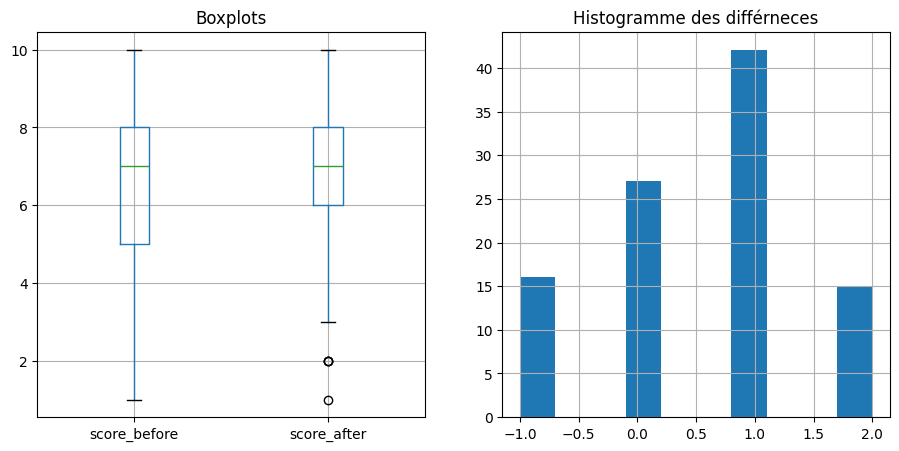

In [283]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))

ax1 = axes[0]
df_satisfaction[["score_before", "score_after"]].boxplot(ax=ax1)
ax1.set_title("Boxplots")

ax2 = axes[1]
df_satisfaction["difference"].hist(ax=ax2)
ax2.set_title("Histogramme des différneces")

**Q4.3** : Testez la normalité de la **distribution des différences**. Est-elle normale ?

In [284]:
stat_shapiro, p_value_shapiro = shapiro(df_satisfaction["difference"])
print("p-value : ", p_value_shapiro)

p-value :  8.337768213811582e-08


- On rejette la normalité de la différence.

**Q4.4** : Justifiez le choix entre un **test t apparié** et un **test de Wilcoxon signé**.

- test sur échantillon apparié
- la différence des échantillons n'est pas normale

**Q4.5** : Réalisez le **test de Wilcoxon pour échantillons appariés** (signed-rank test).

In [294]:
stat_wilcoxon, p_value_wilcoxon = wilcoxon(
    df_satisfaction["score_before"], df_satisfaction["score_after"]
)
print("p-value : ", p_value_wilcoxon)

p-value :  2.432058916932626e-07


- On rejette H0, la différence des moyennes est significative.

**Q4.6** : Calculez le **pourcentage d'utilisateurs** dont le score a augmenté, diminué ou resté stable.

In [ ]:
df_satisfaction["augmentation"] = (
    df_satisfaction["score_before"] < df_satisfaction["score_after"]
)
df_satisfaction["diminution"] = (
    df_satisfaction["score_before"] > df_satisfaction["score_after"]
)
df_satisfaction["stable"] = (
    df_satisfaction["score_before"] == df_satisfaction["score_after"]
)

print(
    "Pourcentage d'utilisateurs dont le score a augmenté",
    df_satisfaction["augmentation"].sum() / len(df_satisfaction) * 100,
)
print(
    "Pourcentage d'utilisateurs dont le score a diminué",
    df_satisfaction["diminution"].sum() / len(df_satisfaction) * 100,
)
print(
    "Pourcentage d'utilisateurs dont le score est resté stable",
    df_satisfaction["stable"].sum() / len(df_satisfaction) * 100,
)

Pourcentage d'utilisateurs dont le score a augmenté 56.99999999999999
Pourcentage d'utilisateurs dont le score a diminué 16.0
Pourcentage d'utilisateurs dont le score est resté stable 27.0


**Q4.7** : Calculez la **taille d'effet** (r = Z / √N pour Wilcoxon).

In [295]:
# effect_size = zstatistic / np.sqrt(len(df_satisfaction))
# print(effect_size)

**Q4.8** : **Recommandation** : La mise à jour a-t-elle significativement amélioré la satisfaction ? Faut-il la déployer à tous les utilisateurs ?

- Moyennes significativement différentes.
- 57 % des utilisateurs ont augmenté leur score de satisfaction
- On déploie !

## Partie 5 : Analyse Complète et Reporting

### Mission Finale

Vous devez présenter vos résultats au **comité de direction**. Préparez un rapport synthétique incluant :

**Q5.1** : **Dashboard récapitulatif** : Créez une visualisation unique (figure avec subplots) résumant les 4 analyses.

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

**Q5.2** : **Tableau de synthèse** :

| Expérimentation | Test utilisé | P-value | Significatif ? | Taille d'effet | Recommandation |
|----------------|--------------|---------|----------------|----------------|----------------|
| Page produit   | ... | ... | ... | ... | ... |
| Promotions     | ... | ... | ... | ... | ... |
| Algorithmes    | ... | ... | ... | ... | ... |
| Satisfaction   | ... | ... | ... | ... | ... |

**Q5.3** : **Calcul de l'impact business global** :
- Revenus supplémentaires estimés si toutes les recommandations sont appliquées
- Priorisation des actions (quick wins vs. long terme)

**Q5.4** : **Limites et biais potentiels** :
- Identifiez les limites de chaque expérimentation
- Quels biais auraient pu affecter les résultats ?
- Quelles analyses complémentaires recommanderiez-vous ?